###### Inicialização

In [1]:
!pip install meteostat yfinance missingno


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from IPython.display import Markdown

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)
import plotly.graph_objects as go

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Análise de Séries temporais (Sessão 8)
---
Pré-processamento (parte 5)

## Auto correlação



Uma importante característica de uma série temporal é a sua correlação serial.

1) A autocorrelação é uma adimensional da associação linear entre duas variáveis aleatórias

\begin{align}
p(h) = Cor(X_t,X_{t-h}) = \frac{Cov(X_t,X_{t-h})}{\sqrt{Var(X_t)Var(X_{t-h})}}
\end{align}

- A autocorrelação depende apenas do intervalo entre as medidas (h).
- Um valor de autocorrelação para um certo h é chamado de Coeficiente de Correlação (de Pearson).
- A autocorrelação varia entre -1 e 1 para uma perfeita correlação linear negativa e positiva, respectivamente.
- Uma autocorrelação igual à ZERO significa nenhuma correlação ou seja as variáveis são independentes!

<center>

![image](https://upload.wikimedia.org/wikipedia/commons/1/10/Correlation_examples_1.png)

Imagem 1 - Exemplos de autocorrelação (fonte: [Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/1/10/Correlation_examples_1.png))
</center>

#### Construindo dados sintéticos

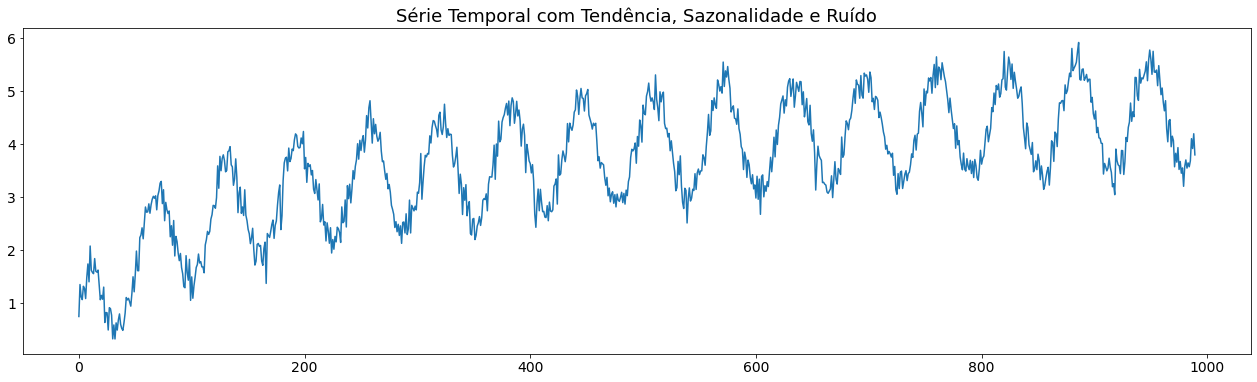

In [33]:
x = np.arange(1, 100, 0.1)
T = pd.Series(np.log(x))

S = pd.Series(np.sin(x))

mu, sigma = 0, .2
R =  pd.Series(np.random.randn(len(x)) * sigma + mu)

X = T + S + R
_ = X.plot(kind='line', title="Série Temporal com Tendência, Sazonalidade e Ruído")

#### Obtendo dados reais

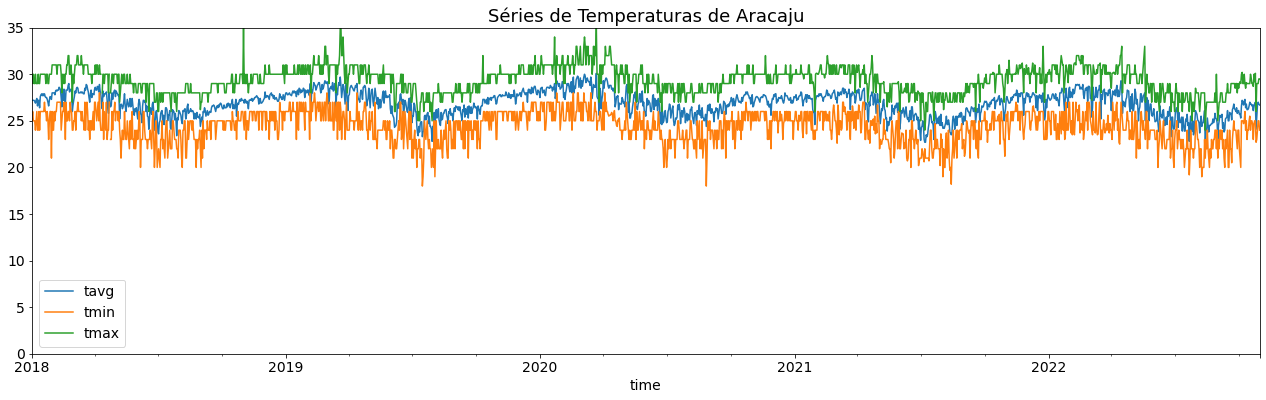

In [34]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

_ = serie_aracaju.plot(y=['tavg', 'tmin', 'tmax'], title="Séries de Temperaturas de Aracaju", ylim=(0,35))

#### Aplicando nos dados sintéticos

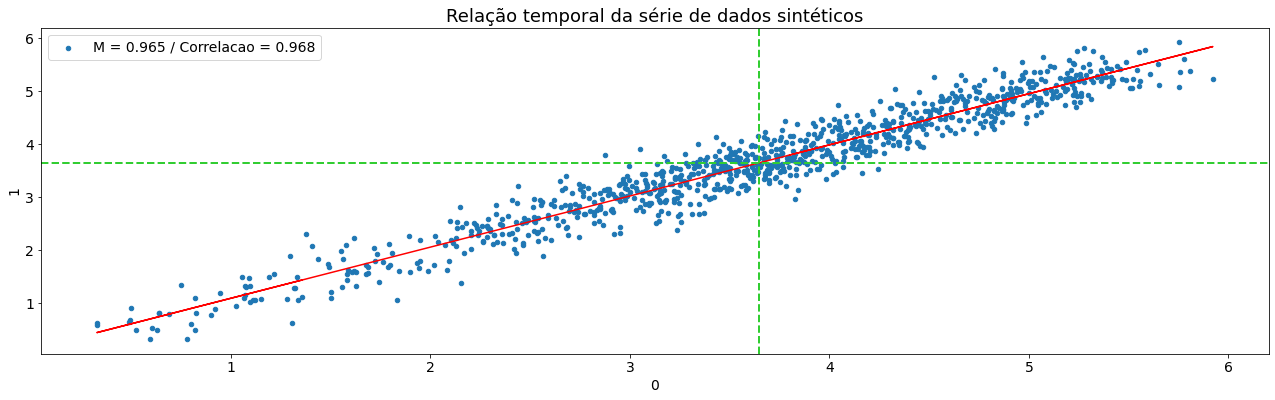

In [35]:
serie = pd.concat([X, X.shift(-1)],axis=1)
correlacao = serie.corr().values[0,1]

m, b = np.polyfit(serie[:-1][0], serie[:-1][1], 1)

serie.plot(x=0, y=1, title="Relação temporal da série de dados sintéticos", kind='scatter', label=f"M = {m:.3f} / Correlacao = {correlacao:.3f}")

plt.plot(serie[0].values[1:], m * serie[0].values[1:] + b, "-r")

plt.axvline(serie[0].mean(), color='limegreen', ls='--', lw=2)
_ = plt.axhline(serie[1].mean(), color='limegreen', ls='--', lw=2)

In [36]:
Xlags = pd.concat([X.shift(-x) for x in range(len(X))],axis=1)

In [37]:
Xlags.iloc[1:10,1:10].style.background_gradient(cmap='Reds')

,1,2,3,4,5,6,7,8,9
1,1.121317,1.070813,1.322450,1.281340,1.090621,1.486557,1.743488,1.405934,2.081560
2,1.070813,1.322450,1.281340,1.090621,1.486557,1.743488,1.405934,2.081560,1.624996
3,1.322450,1.281340,1.090621,1.486557,1.743488,1.405934,2.081560,1.624996,1.584067
4,1.281340,1.090621,1.486557,1.743488,1.405934,2.081560,1.624996,1.584067,1.560324
5,1.090621,1.486557,1.743488,1.405934,2.081560,1.624996,1.584067,1.560324,1.844730
6,1.486557,1.743488,1.405934,2.081560,1.624996,1.584067,1.560324,1.844730,1.605940
7,1.743488,1.405934,2.081560,1.624996,1.584067,1.560324,1.844730,1.605940,1.588775
8,1.405934,2.081560,1.624996,1.584067,1.560324,1.844730,1.605940,1.588775,1.627633
9,2.081560,1.624996,1.584067,1.560324,1.844730,1.605940,1.588775,1.627633,1.336587


In [38]:
Xlags.corr().iloc[1:10,1:10].style.background_gradient(cmap='Reds')

,1,2,3,4,5,6,7,8,9
1,1.000000,0.967919,0.959607,0.949714,0.936056,0.918512,0.898416,0.872925,0.845398
2,0.967919,1.000000,0.967791,0.959448,0.949496,0.935776,0.918154,0.898003,0.872505
3,0.959607,0.967791,1.000000,0.967621,0.959265,0.949254,0.935435,0.917823,0.897717
4,0.949714,0.959448,0.967621,1.000000,0.967485,0.959075,0.948977,0.935192,0.917638
5,0.936056,0.949496,0.959265,0.967485,1.000000,0.967337,0.958897,0.948771,0.935011
6,0.918512,0.935776,0.949254,0.959075,0.967337,1.000000,0.967188,0.958735,0.948653
7,0.898416,0.918154,0.935435,0.948977,0.958897,0.967188,1.000000,0.967096,0.958728
8,0.872925,0.898003,0.917823,0.935192,0.948771,0.958735,0.967096,1.000000,0.967007
9,0.845398,0.872505,0.897717,0.917638,0.935011,0.948653,0.958728,0.967007,1.000000


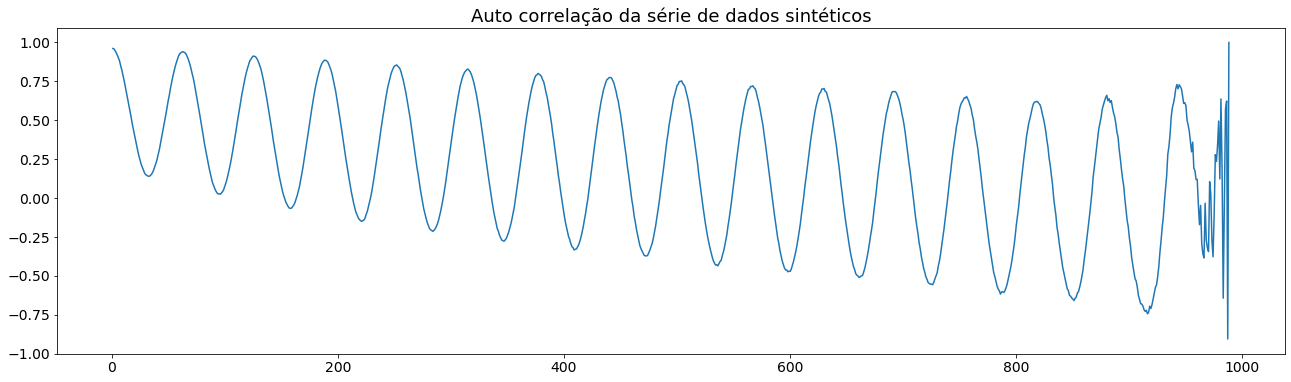

In [10]:
_ = Xlags.corr()[0][1:].plot(title="Auto correlação da série de dados sintéticos")

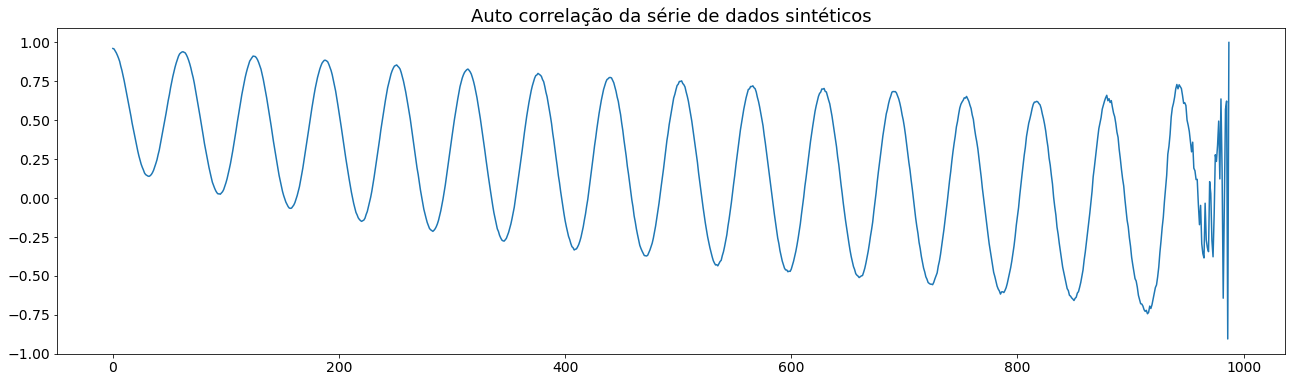

In [11]:
_ = pd.Series([X.autocorr(x) for x in range(len(X)-1)][1:]).plot(title="Auto correlação da série de dados sintéticos")

### Aplicando nos dados reais

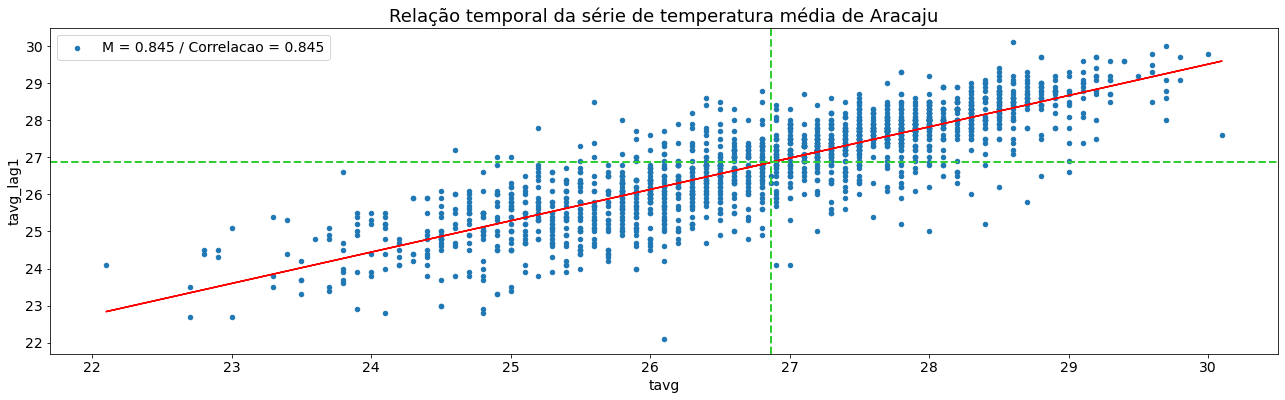

In [12]:
serie_temp = pd.concat([serie_aracaju.tavg, serie_aracaju.tavg.shift(-1).rename('tavg_lag1')],axis=1)
correlacao_temp = serie_temp.corr().values[0,1]

m, b = np.polyfit(serie_temp[:-1]['tavg'], serie_temp[:-1]['tavg_lag1'], 1)

serie_temp.plot(x=0, y=1, title="Relação temporal da série de temperatura média de Aracaju", kind='scatter',
                  label=f"M = {m:.3f} / Correlacao = {correlacao_temp:.3f}")

plt.plot(serie_temp['tavg'].values[1:], m * serie_temp['tavg'].values[1:] + b, "-r")

plt.axvline(serie_temp["tavg"].mean(), color='limegreen', ls='--', lw=2)
_ = plt.axhline(serie_temp["tavg_lag1"].mean(), color='limegreen', ls='--', lw=2)

In [13]:
aracaju_lags = pd.concat([serie_aracaju.tavg.shift(-x).rename(x) for x in range(len(serie_aracaju.tavg))],axis=1)

In [14]:
aracaju_lags.iloc[1:10,1:10].style.background_gradient(cmap='Reds')

,1,2,3,4,5,6,7,8,9
time,,,,,,,,,
2018-01-02 00:00:00,27.200000,27.200000,27.100000,26.900000,27.200000,27.400000,26.600000,27.200000,27.200000
2018-01-03 00:00:00,27.200000,27.100000,26.900000,27.200000,27.400000,26.600000,27.200000,27.200000,26.400000
2018-01-04 00:00:00,27.100000,26.900000,27.200000,27.400000,26.600000,27.200000,27.200000,26.400000,27.600000
2018-01-05 00:00:00,26.900000,27.200000,27.400000,26.600000,27.200000,27.200000,26.400000,27.600000,27.800000
2018-01-06 00:00:00,27.200000,27.400000,26.600000,27.200000,27.200000,26.400000,27.600000,27.800000,27.900000
2018-01-07 00:00:00,27.400000,26.600000,27.200000,27.200000,26.400000,27.600000,27.800000,27.900000,27.700000
2018-01-08 00:00:00,26.600000,27.200000,27.200000,26.400000,27.600000,27.800000,27.900000,27.700000,27.900000
2018-01-09 00:00:00,27.200000,27.200000,26.400000,27.600000,27.800000,27.900000,27.700000,27.900000,27.700000
2018-01-10 00:00:00,27.200000,26.400000,27.600000,27.800000,27.900000,27.700000,27.900000,27.700000,27.900000


In [39]:
aracaju_lags.corr().iloc[1:10,1:10].style.background_gradient(cmap='Reds')

,1,2,3,4,5,6,7,8,9
1,1.000000,0.845124,0.778889,0.752563,0.738452,0.731634,0.717769,0.711026,0.714808
2,0.845124,1.000000,0.845119,0.778881,0.752558,0.738461,0.731624,0.717757,0.711075
3,0.778889,0.845119,1.000000,0.845113,0.778877,0.752568,0.738452,0.731613,0.717807
4,0.752563,0.778881,0.845113,1.000000,0.845110,0.778887,0.752558,0.738441,0.731664
5,0.738452,0.752558,0.778877,0.845110,1.000000,0.845115,0.778883,0.752559,0.738476
6,0.731634,0.738461,0.752568,0.778887,0.845115,1.000000,0.845127,0.778913,0.752571
7,0.717769,0.731624,0.738452,0.752558,0.778883,0.845127,1.000000,0.845123,0.778965
8,0.711026,0.717757,0.731613,0.738441,0.752559,0.778913,0.845123,1.000000,0.845219
9,0.714808,0.711075,0.717807,0.731664,0.738476,0.752571,0.778965,0.845219,1.000000


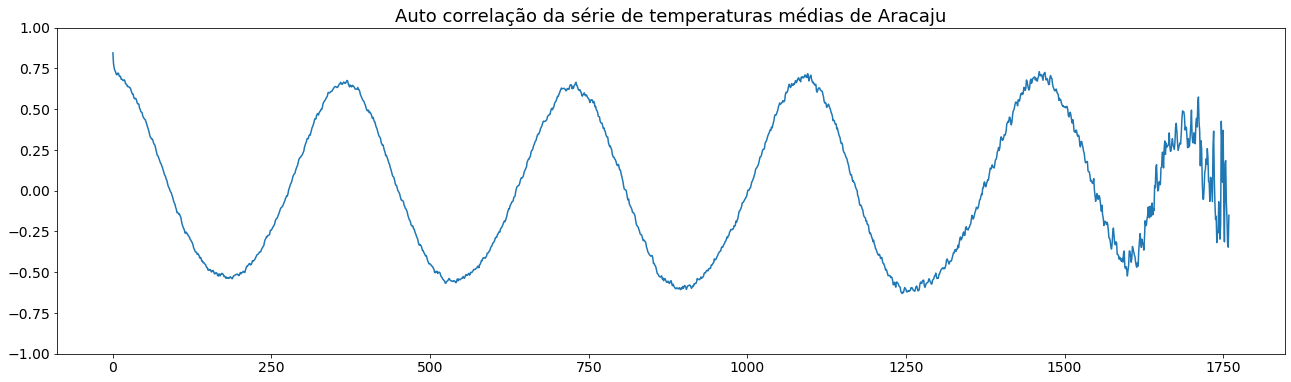

In [16]:
_ = pd.Series([serie_aracaju.tavg.autocorr(x) for x in range(len(serie_aracaju.tavg)-1)][1:]).plot(title="Auto correlação da série de temperaturas médias de Aracaju", ylim=(-1,1))

### Ferramentas para exibir a função de autocorrelação (Correlograma)

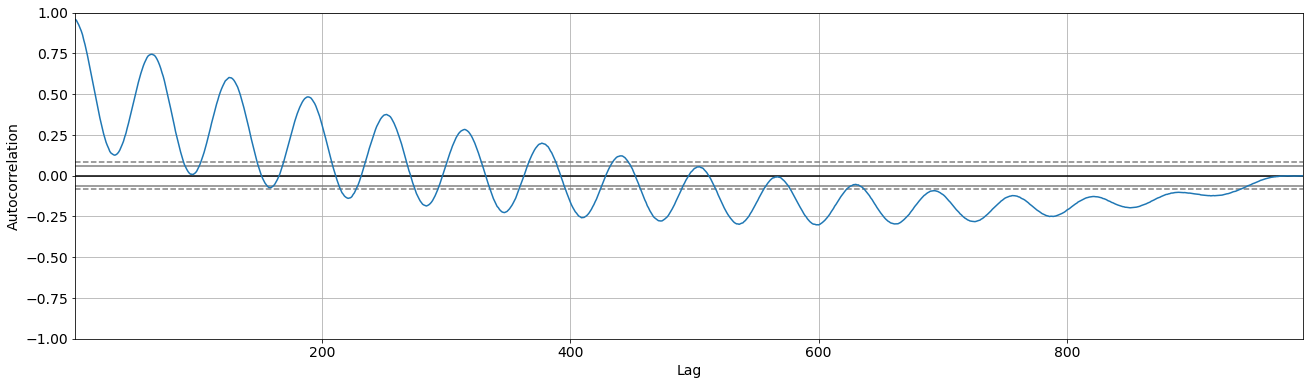

In [17]:
_ = pd.plotting.autocorrelation_plot(X)

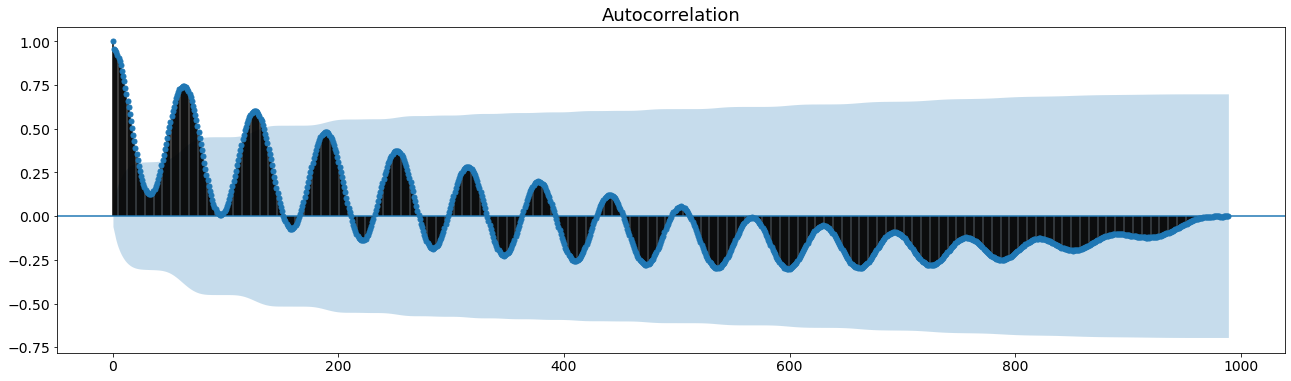

In [18]:
_ = tsa.plot_acf(X, lags=len(x)-1)

- Quando o intervalo entre as medidas $\rho(h)$ aumenta, menos pares $(X_{t+h}, X_t)$ existirão.
- A variância de $\rho(h)$ irá aumentar com um maior $h$, o que pode levar a resultados instáveis e a presença de artefatos.
- As correlações respectivas serão menos precisas.

\begin{align}
\rho(h) = \frac{Cov(X_{t+h},X_t)}{Cov(X_t,X_t)} = \frac{\sum_{s=1}^{n-h}(X_{s+h} - \overline{X})(X_s - \overline{X})}{\sum_{t=1}^{n}(X_t - \overline{X})^2}
\end{align}

##### Validando em dados sintéticos

In [40]:
n = len(X)
c0 = ((X - X.mean()) ** 2).sum()
plugin = lambda h : ((X[:n - h] - X.mean()).values * (X[h:] - X.mean()).values).sum() / c0

autocorr_sinteticos = [plugin(loc) for loc in (np.arange(n) + 1)]

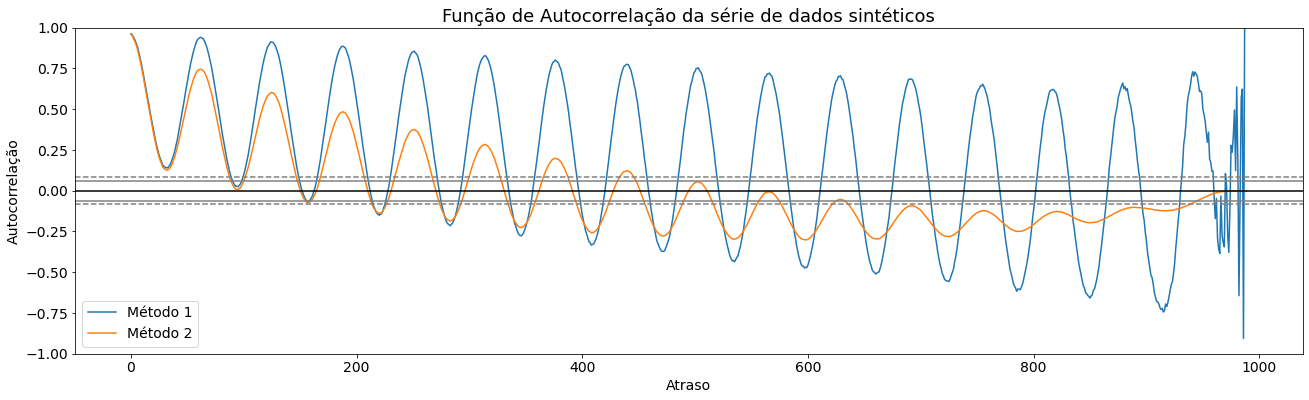

In [20]:
ax = pd.Series([X.autocorr(x) for x in range(n-1)][1:]).plot(label="Método 1", legend= True)
pd.Series(autocorr_sinteticos).plot(ax = ax, title = "Função de Autocorrelação da série de dados sintéticos", label="Método 2", legend= True)

z95 = 1.959963984540054
z99 = 2.5758293035489004

ax.axhline(y=z99 / np.sqrt(n), linestyle="--", color="grey")
ax.axhline(y=z95 / np.sqrt(n), color="grey")
ax.axhline(y=0.0, color="black")
ax.axhline(y=-z95 / np.sqrt(n), color="grey")
ax.axhline(y=-z99 / np.sqrt(n), linestyle="--", color="grey")
ax.set_ylim(-1.0, 1.0)
ax.set_xlabel("Atraso")
_ = ax.set_ylabel("Autocorrelação")

##### Validando em dados reais

In [41]:
X1 = serie_aracaju.tavg

n = len(X1)
c0 = ((X1 - X1.mean()) ** 2).sum()
rho = lambda h : ((X1[:n - h] - X1.mean()).values * (X1[h:] - X1.mean()).values).sum() / c0

autocorr_temp = [rho(loc) for loc in (np.arange(n) + 1)]

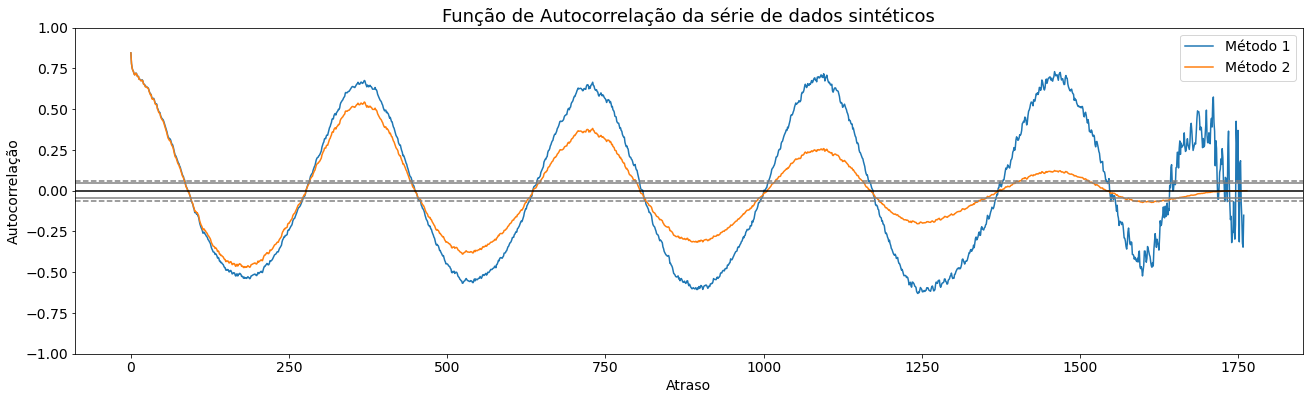

In [42]:
ax = pd.Series([X1.autocorr(x) for x in range(n-1)][1:]).plot(title = "Função de Autocorrelação da série de dados sintéticos",
                                                              label="Método 1", legend= True)
pd.Series(autocorr_temp).plot(ax = ax, label="Método 2", legend= True)

z95 = 1.959963984540054
z99 = 2.5758293035489004

ax.axhline(y=z99 / np.sqrt(n), linestyle="--", color="grey")
ax.axhline(y=z95 / np.sqrt(n), color="grey")
ax.axhline(y=0.0, color="black")
ax.axhline(y=-z95 / np.sqrt(n), color="grey")
ax.axhline(y=-z99 / np.sqrt(n), linestyle="--", color="grey")
ax.set_ylim(-1.0, 1.0)
ax.set_xlabel("Atraso")
_ = ax.set_ylabel("Autocorrelação")

### Comporamentos por tipos de Séries temporais 

##### 1. Sazonal + Ruído (Sem tendência)

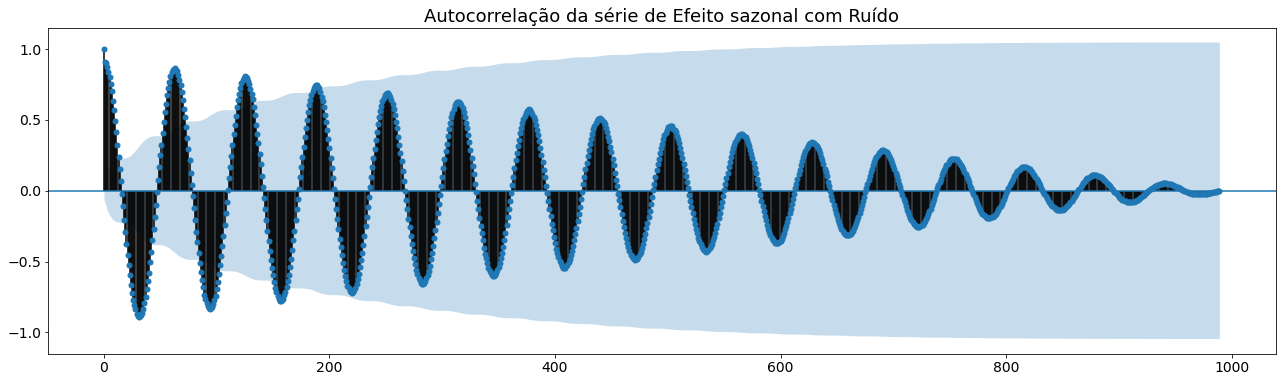

In [23]:
_ = tsa.plot_acf((S+R), lags=len(X)-1, title="Autocorrelação da série de Efeito sazonal com Ruído")

##### 2. Tendência + Ruído

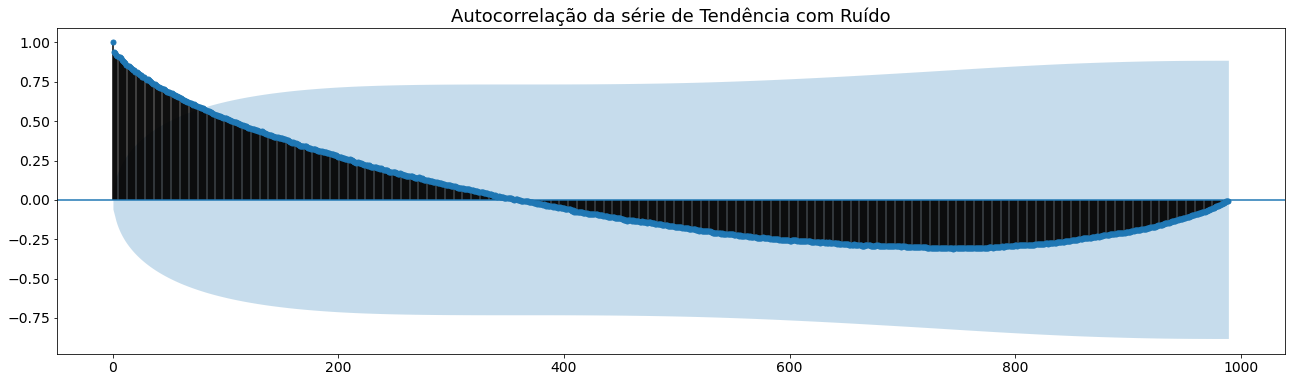

In [24]:
_ = tsa.plot_acf((T+R), lags=len(X)-1, title="Autocorrelação da série de Tendência com Ruído")

##### 3. Tendência decrescente + Ruído

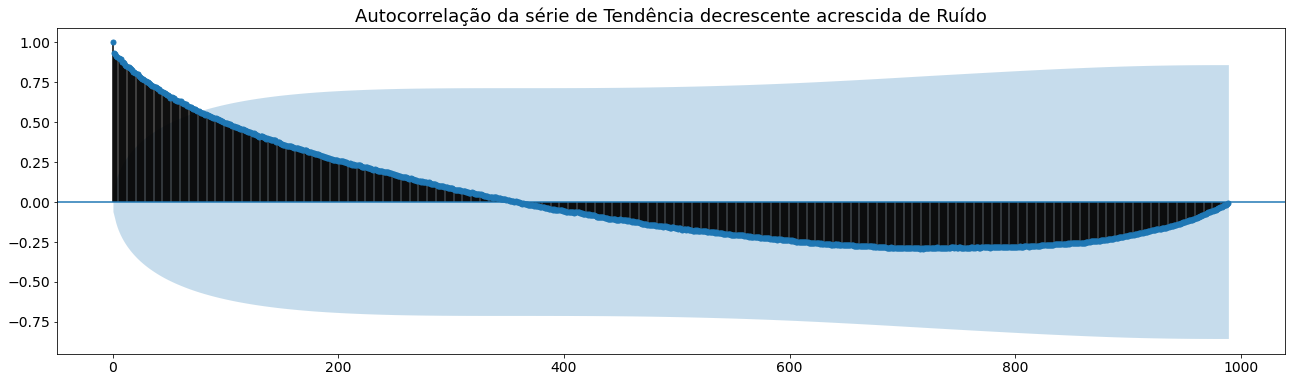

In [25]:
_ = tsa.plot_acf((-T+R), lags=len(X)-1, title="Autocorrelação da série de Tendência decrescente acrescida de Ruído")

##### 4. Apenas Ruído

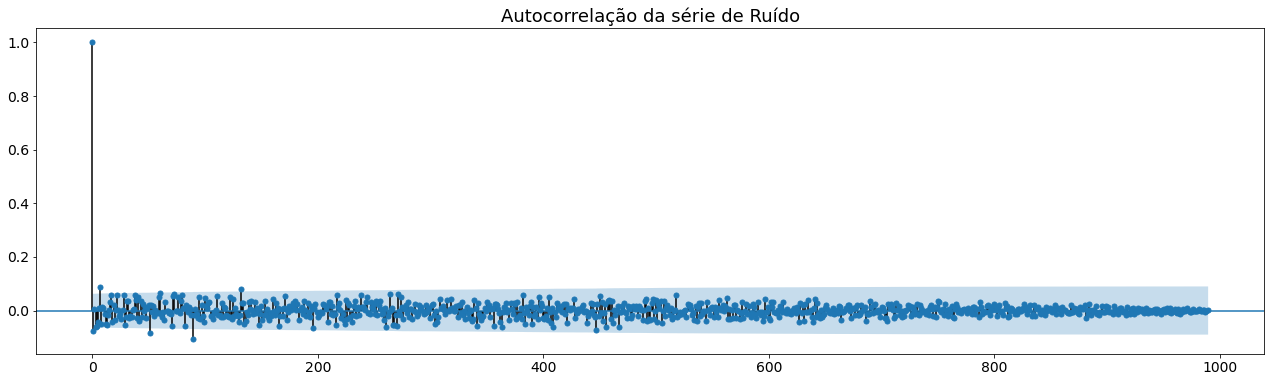

In [26]:
_ = tsa.plot_acf(R, lags=len(X)-1, title="Autocorrelação da série de Ruído")

##### 5. Estácionária 

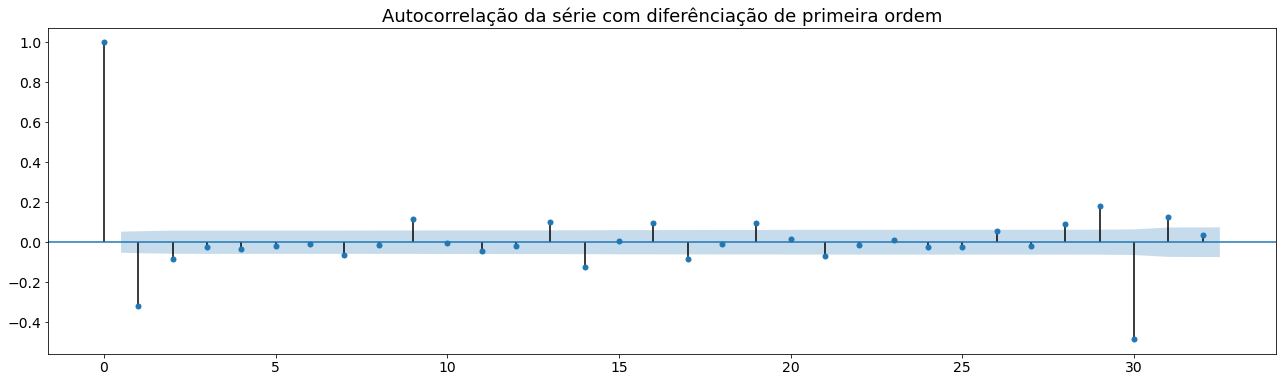

In [27]:
temp_diferenciada = serie_aracaju.tavg.diff(365).diff(30).diff().dropna()
_ = tsa.plot_acf(temp_diferenciada, title="Autocorrelação da série com diferênciação de primeira ordem")

##### 6. Com Outliers

In [28]:
X_outliers = X.copy()

In [29]:
X_outliers.iloc[200] = 50
X_outliers.iloc[300] = 35
X_outliers.iloc[500] = -12
X_outliers.iloc[800] = -20

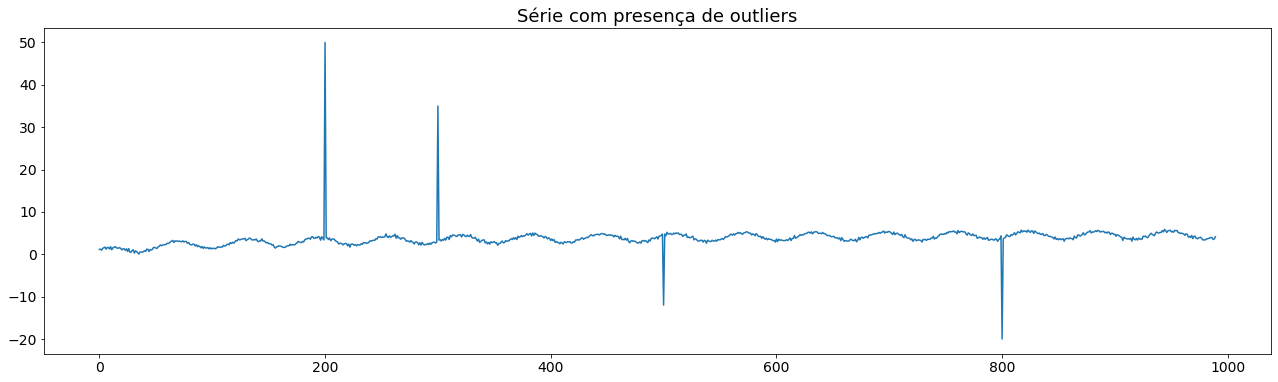

In [30]:
_ = X_outliers.plot(title = 'Série com presença de outliers')

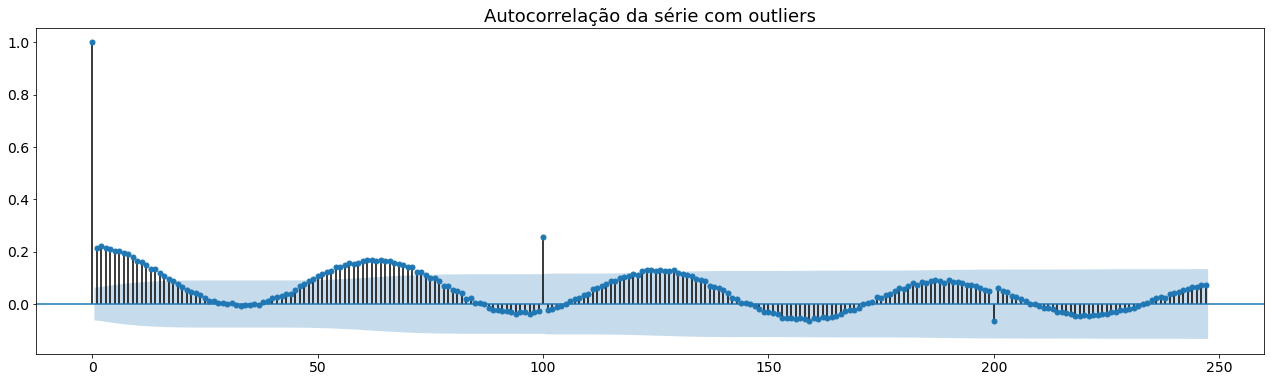

In [31]:
_ = tsa.plot_acf(X_outliers, lags=len(X_outliers)/4, title="Autocorrelação da série com outliers")

#### 7. Modelo Múltiplicativo

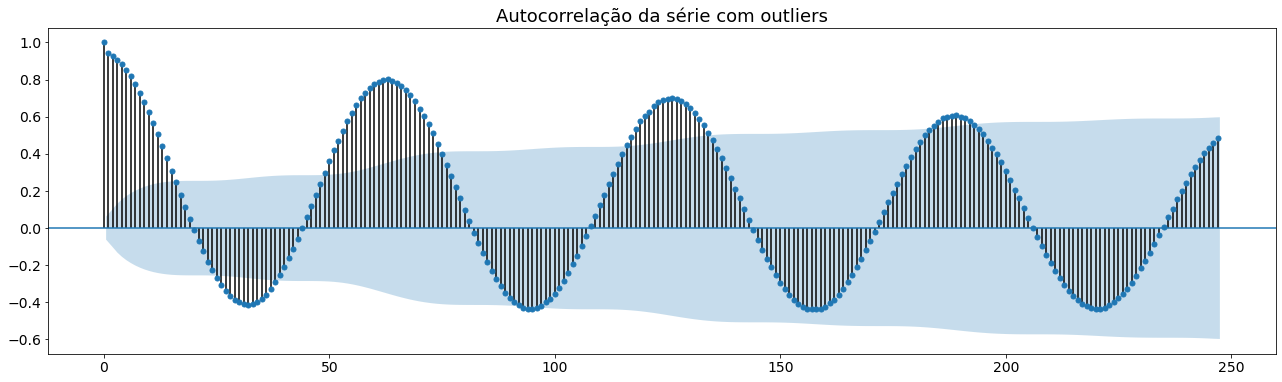

In [32]:
S2 = pd.Series(np.sin(x)) + 2

mu, sigma = 2, .2
R2 =  pd.Series(np.random.randn(len(x)) * sigma + mu)

mult = (T * S2 * R2)
_ = tsa.plot_acf(mult, lags=len(mult)/4, title="Autocorrelação da série com outliers")

## Exercício


1. Calcule e exiba a matriz de autocorrelação das séries de câmbio dólar/real, euro/real e dólar/yuan chinês.
2. Calcule e exiba a funcão de autocorrelação (correlograma) das séries de câmbio dólar/real, euro/real e dólar/yuan chinês.
3. Exiba o correlograma dos componentes de tendência, sazonalidade e ruído da série se temperatura da sua cidade.